# Maping and plotting mean depth isotherms

This notebook extract from temperature database the mean depth of a given `list` of isotherms over time.

In [1]:
#increase the display size to 95% of window width
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:95% !important; }</style>"))

import os
import gc
import sys
import glob
import string
import numpy as np
import pylab as pl
import xarray as xr
import pandas as pd
import matplotlib as mpl
import mpl_toolkits.axisartist
import matplotlib.pyplot as plt


from scipy.interpolate import interp1d
from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)


path = os.getcwd().split('/')
machine_path = '/'+path[1]+'/'+path[2] #cat the /home/user/ or /Users/user from system using path

sys.path.insert(0, f"{machine_path}/opt/mandyoc-scripts/functions")
from mandyocIO import read_mandyoc_output, read_datasets, read_particle_path, single_plot, change_dataset, plot_property, _extract_interface, find_nearest

In [2]:
#Set scenario path
local = False
# local = True
if(local==True):
    model_path = machine_path
else:
    external_media = 'Joao_Macedo'
    model_path = f"/media/{machine_path.split('/')[-1]}/{external_media}"

scenarios = [
             f"{model_path}/Doutorado/cenarios/mandyoc/stable/lit80km/stable_PT200_rheol19_c1250_C1_HprodAst",
             ]

print(f"Scernarios:")
for scenario in scenarios:
    print(f"{scenario.split('/')[-1]}")

dataset = xr.open_dataset(f'{scenarios[0]}/_output_temperature.nc')

Nx = int(dataset.nx)
Nz = int(dataset.nz)
Lx = float(dataset.lx)
Lz = float(dataset.lz)

x = np.linspace(0, Lx/1000.0, Nx)
z = np.linspace(Lz/1000.0, 0, Nz)
Z = np.linspace(Lz/1000.0, 0, 8001) #zi

xx, zz  = np.meshgrid(x, z)

print(dataset.info)

Scernarios:
stable_PT200_rheol19_c1250_C1_HprodAst
<bound method Dataset.info of <xarray.Dataset>
Dimensions:      (time: 401, x: 161, z: 71)
Coordinates:
  * time         (time) float64 0.0 2.5 5.0 7.5 10.0 ... 992.5 995.0 997.5 1e+03
    step         (time) int32 ...
  * x            (x) float64 0.0 1e+04 2e+04 3e+04 ... 1.58e+06 1.59e+06 1.6e+06
  * z            (z) float64 -7e+05 -6.9e+05 -6.8e+05 ... -2e+04 -1e+04 0.0
Data variables:
    temperature  (time, x, z) float64 ...
Attributes: (12/94)
    nx:                                161
    nz:                                71
    lx:                                1600000.0
    lz:                                700000.0
    multigrid:                         1
    solver:                            direct
    ...                                ...
    temperature_units:                 C
    density_units:                     kg/m^3
    heat_units:                        W/m^3
    viscosity_units:                   Pa s
    str

In [3]:
t0 = dataset.time[0]
t1 = dataset.time[1]
dt = int(t1 - t0)

start = int(t0)
end = int(dataset.time.size - 1)
step = 1

# start = 0
# end = 1
# step = 1

# interfaces = [0, 500, 800, 1000, 1300, 1400, 1500, 1600, 1700] #isotherms to be extracted
interfaces = [0, 500, 800, 1300] #isotherms to be extracted
# interfaces = [0]

nrows=len(range(start, end+step, step))
ncols=len(interfaces)+2 # +2 is to add step and time columns
isots_evolution = []

for i in range(start, end+step, step):
    
    Datai = dataset['temperature'][i].values.T
    time  = float(dataset.time[i].values)
    stp  = int(dataset.step[i].values)

    per = np.round(100*(i+1-start)/(end-start), 2)
    text = f"Time: {np.round(float(time), 2)} Myr; Step: {int(stp)}/{int(dataset.step.max())}, ({per:.2f}%)."
    print(text, end='\r')

    isots_evolution.append(time)
    isots_evolution.append(stp)

    for interface in interfaces:
        interf = _extract_interface(z, Z, Nx, Datai, interface)
        interf_mean = round(np.mean(interf), 2)
        isots_evolution.append(interf_mean)

######################################################################################################################
#Reshape data to plot and/or save
        
isots_evolution = np.asarray(isots_evolution)
data_aux = isots_evolution
isots_evolution = isots_evolution.reshape(nrows, ncols)

#create xarray dataset of isotherms evolution
coords = {"time": isots_evolution[::,0], "step": ("time", np.asarray(isots_evolution[::,1], dtype=int))}
dims = ("time")
data_aux = isots_evolution[::,2::]

ds = xr.Dataset(coords=coords)

for i in range(len(interfaces)):
    ds[f"isot{interfaces[i]}"] = (dims, data_aux[::,i])

In [4]:
save_txt = True
# save_txt = False

save_dataset = True
# save_dataset = False

if(save_txt):
    filename = f"{scenarios[0]}/{scenarios[0].split('/')[-1]}_isotherms_evolution.txt"
    np.savetxt(filename, isots_evolution)
    
if(save_dataset):
    ds.to_netcdf(f"{scenarios[0]}/_isotherms_evolution.nc")
    ds.to_netcdf(f"{scenarios[0].split('/')[-1]}_isotherms_evolution.nc")

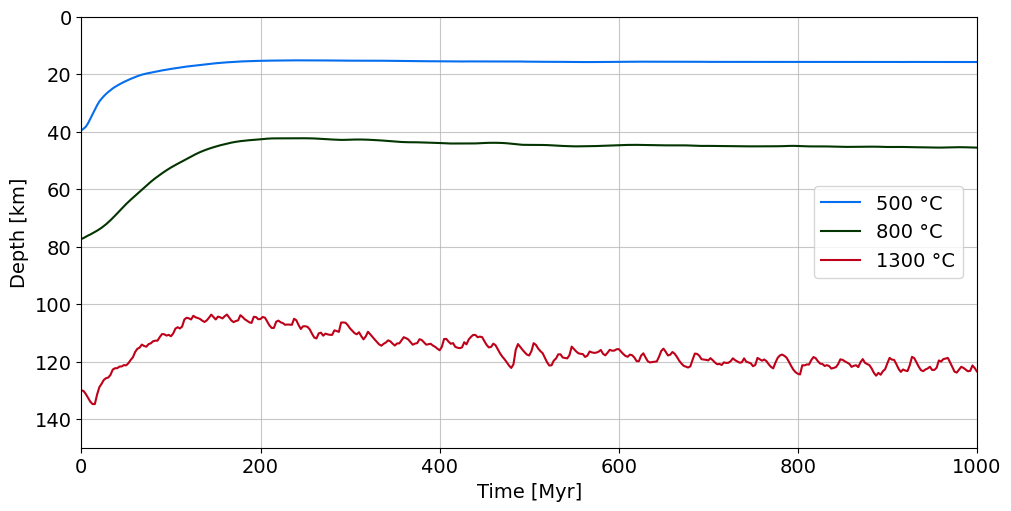

In [17]:
plt.close()
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['xkcd:cerulean blue',
                                                    'xkcd:dark green',
                                                    'xkcd:scarlet',
                                                    'xkcd:light orange',
                                                    'xkcd:lighter purple',
                                                    ]) 
label_fsize = 14
plt.rc('xtick', labelsize=label_fsize)
plt.rc('ytick', labelsize=label_fsize)

fig, ax = plt.subplots(1, 1, figsize=(10, 5), constrained_layout=True)
h_air = 40
for interface in interfaces[1::]:
    ax.plot(ds.time, ds[f'isot{interface}']-h_air, label=f'{interface} °C')


ax.set_ylim([150, 0])
ax.set_xlim([0, 1000])
ax.set_xlabel('Time [Myr]', fontsize=label_fsize)
ax.set_ylabel('Depth [km]', fontsize=label_fsize)

# ax.legend(fontsize=label_fsize)
ax.legend(fontsize=label_fsize, loc='center right', bbox_to_anchor=(0.995, 0.5))
ax.grid('k', alpha=0.7)

figname = f"{scenarios[0].split('/')[-1]}_isotherms_evolution"

save_fig = True
# save_fig = False
if(save_fig):
    fig.savefig(f"figures/{figname}.png", dpi=300)
    fig.savefig(f"figures/{figname}.pdf", dpi=300)
    fig.savefig(f"{scenarios[0]}/{figname}.png", dpi=300)
    fig.savefig(f"{scenarios[0]}/{figname}.pdf", dpi=300)